All features have moved to hor_config
!==================================================================!
!          ISIS utilities for visualization and analysis           !
!                   of neutron spectroscopy data                   !
!                          Herbert 4.0.0                           !
!------------------------------------------------------------------!
All features have moved to hor_config
!==================================================================!
!                           Horace 4.0.0                           !
!------------------------------------------------------------------!
!   Visualisation of multi-dimensional neutron spectroscopy data   !
!                                                                  !
!           R.A. Ewings, A. Buts, M.D. Le, J van Duijn,            !
!                  I. Bustinduy, and T.G. Perring                  !
!                                                                  !
!             Nucl. Inst. M

RuntimeError: MatlabExecutionError: 
  File "C:\Users\henrikjacobsen3\AppData\Local\Temp\henrikjacobsen3\mcrCache9.14\pace_21\pace_2023a\buildtmp\CTF\Horace\horace_core\sqw\file_io\@sqw_formats_factory\private\get_loader_.m", line 36, function "get_loader_"
  File "C:\Users\henrikjacobsen3\AppData\Local\Temp\henrikjacobsen3\mcrCache9.14\pace_21\pace_2023a\buildtmp\CTF\Horace\horace_core\sqw\file_io\@sqw_formats_factory\sqw_formats_factory.m", line 131, function "sqw_formats_factory.get_loader"
  File "C:\Users\henrikjacobsen3\AppData\Local\Temp\henrikjacobsen3\mcrCache9.14\pace_21\pace_2023a\buildtmp\CTF\Horace\horace_core\algorithms\cut.m", line 67, function "cut_single_obj"
  File "C:\Users\henrikjacobsen3\AppData\Local\Temp\henrikjacobsen3\mcrCache9.14\pace_21\pace_2023a\buildtmp\CTF\Horace\horace_core\algorithms\cut.m", line 49, function "cut"
  File "C:\Users\henrikjacobsen3\AppData\Local\Temp\henrikjacobsen3\mcrCache9.14\pace_21\pace_2023a\buildtmp\CTF\Horace\horace_core\algorithms\cut_sqw.m", line 18, function "cut_sqw"
  File "C:\Users\henrikjacobsen3\AppData\Local\Temp\henrikjacobsen3\mcrCache9.14\pace_21\pace_2023a\src\call.m", line 20, function "call"

HORACE:file_io:runtime_error: get_loader: *** Can not find file: iron.sqw


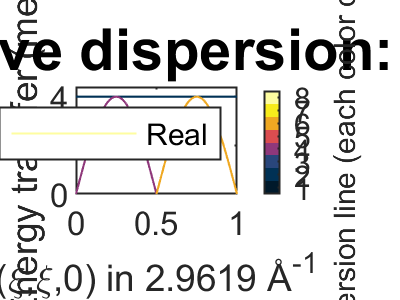

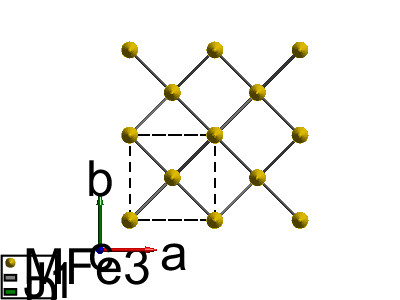

In [3]:
from pace_neutrons import Matlab
m = Matlab()

# from matlab import double as md
import numpy as np

tri = m.sw_model('triAF', 1)
tri.addmatrix('label', 'K', 'value', m.diag([0, 0, -1]))

print(tri.matrix)

af = m.sw_model('squareAF', 1.)
spec = af.spinwave(([0, 0, 0], [1, 1, 0], 500))
hf0 = m.figure()
m.sw_plotspec(spec, nargout=0)

# Now setup the SpinW model and try to run it
a = 2.87;

fe = m.spinw();
fe.genlattice('lat_const', [a, a, a], 'angled', [90, 90, 90], 'spgr', 'I m -3 m')  # bcc Fe
fe.addatom('label', 'MFe3', 'r', [0, 0, 0], 'S', 5/2, 'color', 'gold')
fe.gencoupling()
fe.addmatrix('label', 'J1', 'value', 1, 'color', 'gray')
fe.addmatrix('label', 'D', 'value', m.diag([0, 0, -1]), 'color', 'green')
fe.addcoupling('mat', 'J1', 'bond', 1)
fe.addaniso('D')
fe.genmagstr('mode', 'direct', 'S', np.array([[0., 0., 1.], [0., 0., 1.]]).T);  # Ferromagnetic

hf2 = m.plot(fe, 'range', [2, 2, 2])
#m.uiwait(hf2)

sqw_file = 'iron.sqw'
# Make a series of 1D cuts of the data
proj = {'u':[1,1,0], 'v':[-1,1,0], 'type':'rrr'}
energy_range = range(80, 160, 20)
my_cuts = []
# Evaluating sqw_eval for a list of cuts doesn't work at the moment
for i in [0]:#range(len(energy_range)):
    my_cuts.append(m.cut_sqw(sqw_file, proj, [-3,0.05,3], [-1.05,-0.95], [-0.05,0.05], [-10+energy_range[i], 10+energy_range[i]]));
linear_bg = m.eval('@linear_bg');

# Constant parameters for SpinW model
# Note that we use the damped harmonic oscillator resolution model ('sho')
cpars = ['mat', ['J1', 'D(3,3)'], 'hermit', False, 'optmem', 1,
         'useFast', True, 'resfun', 'sho', 'formfact', True];
#m.swpref.setpref('usemex', True);

# Initial parameters:
J = -16;     # Exchange constant in meV - Note previous value was J*S (S=2.5)
D = -0.1;    # SIA constant in meV
gam = 66;
temp = 10;
amp = 131;

kk = m.multifit_sqw (my_cuts[0]);
kk = kk.set_fun (fe.horace_sqw, [m([J, D, gam, temp, amp])]+cpars)
kk = kk.set_free ([1, 0, 1, 0, 1]);
kk = kk.set_bfun (linear_bg, [0.1,0]);
kk = kk.set_bfree ([1,0]);
kk = kk.set_options ('list',2);

# Time a single iteration
m.tic()
wsim = kk.simulate('comp');
t_spinw_single = m.toc();

# Time the fit
m.tic()
wfit, fitdata = kk.fit('comp');
t_spinw = m.toc();

#for i=1:numel(my_cuts)
m.acolor('black');
hf3 = m.plot(my_cuts[0]);
m.acolor('red');
m.pl(wfit['sum']);
m.pl(wfit['back']);
m.keep_figure;
#end

# Display how long it takes to fit
#if exist('t_ana', 'var');
#    fprintf('Time for analytical fitting = %f s\n', t_ana);
#end
print(f'Time for SpinW single iteration = {t_spinw_single} s')
print(f'Time for SpinW fit = {t_spinw} s')

m.uiwait(hf3)

In [ ]:
demo_FM_spinwaves = m.eval('@(qh, qk, ql, en, pars) (pars(5) .* ((en ./ (1 - exp(-11.602 .* en ./ pars(4)))) .* (4 .* pars(3) .* (pars(2) + (4 * pars(1)) * ((sin(pi .* qh)).^2 + (sin(pi .* qk)).^2 + (sin(pi .* ql)).^2)))) ./ (pi .* ((en - (pars(2) + (4 * pars(1)) * ((sin(pi .* qh)).^2 + (sin(pi .* qk)).^2 + (sin(pi .* ql)).^2))).^2 + 4 .* (pars(3) .* en).^2)))')
w_sqw = m.sqw_eval(cc2, demo_FM_spinwaves, [250, 0, 2.4, 10, 5])
%matlab_fig -w 1600 -h 1200 
m.plot(w_sqw)
# ff = m.eval('@(h,k,l) sum(bsxfun(@times, [{} {} {}], exp(bsxfun(@times, -[{} {} {}], ((1/(2*2.87)).^2 .* (h(:).^2 + k(:).^2 + l(:).^2))))), 2) + {}'.format(A, B, C, a, b, c, D));




In [ ]:




import numpy as np

def demo_FM_spinwaves(qh, qk, ql, en, pars):
    """
    Calculate the spectral weight from a Heisenberg ferromagnet for a Q-E slice
    with nearest-neighbour interactions only.
    
    Parameters:
    qh, qk, ql, en : array-like
        Arrays (or scalars) specifying the co-ordinates for point in (Q,E)-space
        where you wish to calculate the intensity.
    pars : list
        List of parameters [js, delta, gam, temp, amp].

    Returns:
    y : array-like
        Array the same size as the input arrays qvar and en, representing the intensity.
    """
    
    js, delta, gam, temp, amp = pars
    
    # Avoiding divide by zero warning equivalent in Python
    np.seterr(divide='ignore', invalid='ignore')
    
    # Calculate omega0
    omega0 = delta + (4 * js) * ((np.sin(np.pi * qh))**2 + 
                                 (np.sin(np.pi * qk))**2 + 
                                 (np.sin(np.pi * ql))**2)
    
    # Calculate the Bose factor
    Bose = en / (1 - np.exp(-11.602 * en / temp))
    
    # Use damped SHO model to give intensity
    y = amp * (Bose * (4 * gam * omega0) / 
               (np.pi * ((en - omega0)**2 + 4 * (gam * en)**2)))
    
    # Return the calculated intensity
    return y

# Example usage:
qh = np.array([0.1, 0.2, 0.3])
qk = np.array([0.1, 0.2, 0.3])
ql = np.array([0.1, 0.2, 0.3])
en = np.array([10, 20, 30])
pars = [250, 0, 2.4, 10, 5]

# Call the function and print the result
intensity = demo_FM_spinwaves(qh, qk, ql, en, pars)
print("Calculated Intensity:", intensity)


In [ ]:
"""
This a Python translation of an example script from the Horace training course.
In the original script, a multifit() model was setup and fit but this does not
work in Python at the moment because the thinwrapper around old-style Matlab 
classes does not nest (and the multifit object has a nested sqw object inside
it). So it is changed to just use sqw_eval() instead.
"""

# Have to import Matlab first before any CPython modules or will give ABI errors
from pace_neutrons import Matlab
m = Matlab()


In [ ]:

data_path = '/path/to/sqw/'

import numpy as np

# sqw_file = '{}/iron.sqw'.format(data_path)
sqw_file = 'demo.sqw'

# If the data file doesn't exist, create a fake version
#if ~exist(sqw_file, 'file')
#    generate_iron	
#end

# Make a series of 1D cuts of the data
proj = {'u':[1,1,0], 'v':[-1,1,0], 'type':'rrr'}
energy_range = range(80, 160, 20)
my_cuts = []


In [ ]:

# Evaluating sqw_eval for a list of cuts doesn't work at the moment
for i in [0]:#range(len(energy_range)):
    my_cuts.append(m.cut_sqw(sqw_file, proj, [-3,0.05,3], [-1.05,-0.95], [-0.05,0.05], [-10+energy_range[i], 10+energy_range[i]]));


In [ ]:

##
# Run the fitting with an analytical expression for the cross-section
#  - using an exact expression for the dispersion of a body-centered cubic 
#    FM combined with a damped harmonic oscillator for the intensity.
# The parameters of the function is: [JS Delta Gamma Temperature Amplitude]
p0 = [35, 0, 30, 10, 300];
# Expression for the dispersion
om = m.eval('@(h,k,l,e,js,d) d + (8*js)*(1-cos(pi*h).*cos(pi*k).*cos(pi*l))');

In [ ]:
# The magnetic form factor of Fe2+
A=0.0706; a=35.008;  B=0.3589; b=15.358;  C=0.5819; c=5.561;  D=-0.0114;
ff = m.eval('@(h,k,l) sum(bsxfun(@times, [{} {} {}], exp(bsxfun(@times, -[{} {} {}], ((1/(2*2.87)).^2 .* (h(:).^2 + k(:).^2 + l(:).^2))))), 2) + {}'.format(A, B, C, a, b, c, D));
# Put it altogether
m.assignin('base', 'om', om)
m.assignin('base', 'ff', ff)
fe_sqw = m.evalin('base', '@(h,k,l,e,p) ff(h,k,l).^2 .* (p(5)/pi) .* (e./(1-exp(-11.602.*e./p(4)))) .* 4.*p(3).*om(h,k,l,e,p(1),p(2)) ./ ((e.^2-om(h,k,l,e,p(1),p(2)).^2).^2 + 4.*(p(3).*e).^2)');
linear_bg = m.eval('@linear_bg');

# Starting parameters for fit
J = 35;
D_A = 0;
gam = 30;
temp = 10;
amp = 300;

# Define the equivalent Python function
def py_fe_sqw(h, k, l, e, p):
    js = p[0]
    d = p[1]
    om = d + (8*js) * (1 - np.cos(np.pi * h) * np.cos(np.pi * k) * np.cos(np.pi * l))
    q2 = ((1/(2*2.87))**2) * (h**2 + k**2 + l**2)
    ff = A * np.exp(-a*q2) + B * np.exp(-b*q2) + C * np.exp(-c*q2) + D
    return (ff**2) * (p[4]/np.pi) * (e / (1-np.exp(-11.602*e/p[3]))) * (4 * p[2] * om) / ((e**2 - om**2)**2 + 4*(p[2] * e)**2)

fe_sqw

In [ ]:
p=[35, 0, 30, 10, 300]
zeta=0.1
h=1+zeta
k=-1+zeta
l=0
e=100

py_test_result=py_fe_sqw(h, k, l, e, p)
print(py_test_result)

m_test_result=fe_sqw(h, k, l, e, p)
print(m_test_result)


In [ ]:

def ff_py(h,k,l):
    q2 = ((1/(2*2.87))**2) * (h**2 + k**2 + l**2)
    return A * np.exp(-a*q2) + B * np.exp(-b*q2) + C * np.exp(-c*q2) + D

print(ff(h,k,l))
print(ff_py(h,k,l))

In [ ]:

# Call with Matlab function
w_cal_m = m.sqw_eval(my_cuts[0], fe_sqw, [35, 0, 30, 10, 300])


In [ ]:

# Call with Python function
w_cal_py = m.sqw_eval(my_cuts[0], py_fe_sqw, [35, 0, 30, 10, 300])


In [ ]:

w_sum_m = m.cut(w_cal_m, [-999., 999.])
print("Summed counts in Matlab calculated cuts = {}".format(w_sum_m.data.s))
w_sum_py = m.cut(w_cal_py, [-999., 999.])
print("Summed counts in Python calculated cuts = {}".format(w_sum_py.data.s))


%matlab_plot_mode inline
%matlab_fig -w 1200 -h 800 

hf1 = m.plot(w_cal_m)


In [ ]:
%matlab_plot_mode inline
%matlab_fig -w 1200 -h 800 
hf2=m.plot(w_cal_py)

In [ ]:
%matlab_plot_mode inline
%matlab_fig -w 1200 -h 800 
hf2=m.plot(w_cal_py/w_cal_m)
# m.uiwait(hf1)


In [ ]:

kk = m.multifit_sqw(my_cuts[0])
kk = kk.set_fun (fe_sqw, [J, D_A, gam, temp, amp])
kk = kk.set_free ([1, 0, 1, 0, 1])
kk = kk.set_bfun (linear_bg, [0.1,0])
kk = kk.set_bfree ([1,0])
kk = kk.set_options ('list',2)

# Time it to see how long it takes to do the fit
m.tic()
wfit, fitdata = kk.fit('comp')
t_ana = m.toc()
print(t_ana)

In [ ]:
m.pl(wfit['sum'])

In [ ]:
#
# testing the lswt algorithm (https://arxiv.org/abs/1402.6069) directly for comparison,
# both for a 1d ferromagnetic and for an antiferromagnetic chain
# @author Tobias Weber <tweber@ill.fr>
# @date 24-oct-2024
# @license GPLv3, see 'LICENSE' file
#

import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt


is_ferromagnetic = False  # choose ferromagnetic or antiferromagnetic 1d spin chain
only_pos_E = False        # hide magnon annihilation?


#
# magnetic sites
# "S": spin magnitude
# "Sdir": spin direction
#
if is_ferromagnetic:
	sites = [
		{ "S" : 1., "Sdir" : [ 0, 0, 1 ] },
	]
else:  # antiferromagnetic
	sites = [
		{ "S" : 1., "Sdir" : [ 0, 0, 1 ] },
		{ "S" : 1., "Sdir" : [ 0, 0, -1 ] },
	]

#
# magnetic couplings
# "sites": indices of the sites to couple
# "J": (symmetric) exchange interaction
# "DMI": (antisymmetric) Dzyaloshinskii-Moryia interaction
# "dist": distance in rlu to the next unit cell for the coupling
#
if is_ferromagnetic:
	couplings = [
		{ "sites" : [ 0, 0 ], "J" : -1., "DMI" : [ 0, 0, 0 ], "dist" : [ 1, 0, 0 ] },
	]
else:  # antiferromagnetic
	couplings = [
		{ "sites" : [ 0, 1 ], "J" : 1., "DMI" : [ 0, 0, 0 ], "dist" : [ 0, 0, 0 ] },
		{ "sites" : [ 1, 0 ], "J" : 1., "DMI" : [ 0, 0, 0 ], "dist" : [ 2, 0, 0 ] },
	]


# skew-symmetric (cross-product) matrix
def skew(vec):
	return np.array([
		[      0.,   vec[2],  -vec[1] ],
		[ -vec[2],       0.,   vec[0] ],
		[  vec[1],  -vec[0],       0. ] ])


# calculate spin rotations towards ferromagnetic order along [001]
for site in sites:
	zdir = np.array([ 0., 0., 1. ])
	Sdir = np.array(site["Sdir"]) / la.norm(site["Sdir"])
	rotaxis = np.array([ 0., 1., 0. ])
	s = 0.

	if np.allclose(Sdir, zdir):
		# spin and z axis parallel
		c = 1.
	elif np.allclose(Sdir, -zdir):
		# spin and z axis anti-parallel
		c = -1.
	else:
		# sine and cosine of the angle between spin and z axis
		rotaxis = np.cross(Sdir, zdir)
		s = la.norm(rotaxis)
		c = np.dot(Sdir, zdir)
		rotaxis /= s

	# rotation via rodrigues' formula, see (Arens 2015), p. 718 and p. 816
	rot = (1. - c) * np.outer(rotaxis, rotaxis) + np.diag([ c, c, c ]) - skew(rotaxis)*s
	site["u"] = rot[0, :] + 1j * rot[1, :]
	site["v"] = rot[2, :]

	#print(np.dot(rot, Sdir))
	#print("\nrot = \n%s\nu = %s\nv = %s" % (rot, site["u"], site["v"]))



# calculate real interaction matrices
for coupling in couplings:
	J = coupling["J"]
	coupling["J_real"] = np.diag([ J, J, J ]) + skew(coupling["DMI"])

	#print("\nJ_real =\n%s" % coupling["J_real"])


# get the energies of the dispersion at the momentum transfer Qvec
def get_energies(Qvec):
	#print("\n\nQ = %s" % Qvec)

	# fourier transform interaction matrices
	num_sites = len(sites)
	J_fourier = np.zeros((num_sites, num_sites, 3, 3), dtype = complex)
	J0_fourier = np.zeros((num_sites, num_sites, 3, 3), dtype = complex)

	for coupling in couplings:
		dist = np.array(coupling["dist"])
		J_real = coupling["J_real"]
		site1 = coupling["sites"][0]
		site2 = coupling["sites"][1]

		J_ft = J_real * np.exp(-1j * 2.*np.pi * np.dot(dist, Qvec))
		J_fourier[site1, site2] += J_ft
		J_fourier[site2, site1] += J_ft.transpose().conj()
		J0_fourier[site1, site2] += J_real
		J0_fourier[site2, site1] += J_real.transpose().conj()

	#print("\nJ_fourier =\n%s\n\nJ0_fourier =\n%s" % (J_fourier, J0_fourier))


	# hamiltonian
	H = np.zeros((2*num_sites, 2*num_sites), dtype = complex)

	for i in range(num_sites):
		S_i = sites[i]["S"]
		u_i = sites[i]["u"]
		v_i = sites[i]["v"]

		for j in range(num_sites):
			S_j = sites[j]["S"]
			u_j = sites[j]["u"]
			v_j = sites[j]["v"]
			S = 0.5 * np.sqrt(S_i * S_j)

			H[i, j] += S * np.dot(u_i, np.dot(J_fourier[i, j], u_j.conj()))
			H[i, i] -= S_j * np.dot(v_i, np.dot(J0_fourier[i, j], v_j))
			H[num_sites + i, num_sites + j] += \
				S * np.dot(u_i.conj(), np.dot(J_fourier[i, j], u_j))
			H[num_sites + i, num_sites + i] -= \
				S_j * np.dot(v_i, np.dot(J0_fourier[i, j], v_j))
			H[i, num_sites + j] += \
				S * np.dot(u_i, np.dot(J_fourier[i, j], u_j))
			H[num_sites + i, j] += \
				(S * np.dot(u_j, np.dot(J_fourier[j, i], u_i))).conj()

	#print("\nH =\n%s" % H)


	# trafo
	C = la.cholesky(H)
	signs = np.diag(np.concatenate((np.repeat(1, num_sites), np.repeat(-1, num_sites))))
	H_trafo = np.dot(C.transpose().conj(), np.dot(signs, C))

	#print("\nC =\n%s\n\nH_trafo =\n%s" % (C, H_trafo))


	# the eigenvalues of H give the energies
	Es = np.real(la.eigvals(H_trafo))
	return Es


# plot a dispersion branch
hs = []
Es = []
for h in np.linspace(-1, 1, 1024):
	try:
		Qvec = np.array([ h, 0, 0 ])
		for E in get_energies(Qvec):
			if only_pos_E and E < 0.:
				continue
			hs.append(h)
			Es.append(E)
	except la.LinAlgError:
		pass

plt.plot()
plt.xlabel("h (rlu)")
plt.ylabel("E (meV)")
plt.scatter(hs, Es, marker = '.')
plt.show()

In [ ]:
from pace_neutrons import Matlab
m = Matlab()

# from matlab import double as md
import numpy as np

tri = m.sw_model('triAF', 1)
tri.addmatrix('label', 'K', 'value', m.diag([0, 0, -1]))

print(tri.matrix)

af = m.sw_model('squareAF', 1.)
spec = af.spinwave(([0, 0, 0], [1, 1, 0], 500))
hf0 = m.figure()
m.sw_plotspec(spec, nargout=0)

# Now setup the SpinW model and try to run it
a = 2.87;

fe = m.spinw();
fe.genlattice('lat_const', [a, a, a], 'angled', [90, 90, 90], 'spgr', 'I m -3 m')  # bcc Fe
fe.addatom('label', 'MFe3', 'r', [0, 0, 0], 'S', 5/2, 'color', 'gold')
fe.gencoupling()
fe.addmatrix('label', 'J1', 'value', 1, 'color', 'gray')
fe.addmatrix('label', 'D', 'value', m.diag([0, 0, -1]), 'color', 'green')
fe.addcoupling('mat', 'J1', 'bond', 1)
fe.addaniso('D')
fe.genmagstr('mode', 'direct', 'S', np.array([[0., 0., 1.], [0., 0., 1.]]).T);  # Ferromagnetic

hf2 = m.plot(fe, 'range', [2, 2, 2])
#m.uiwait(hf2)

sqw_file = 'iron.sqw'
# Make a series of 1D cuts of the data
proj = {'u':[1,1,0], 'v':[-1,1,0], 'type':'rrr'}
energy_range = range(80, 160, 20)
my_cuts = []
# Evaluating sqw_eval for a list of cuts doesn't work at the moment
for i in [0]:#range(len(energy_range)):
    my_cuts.append(m.cut_sqw(sqw_file, proj, [-3,0.05,3], [-1.05,-0.95], [-0.05,0.05], [-10+energy_range[i], 10+energy_range[i]]));
linear_bg = m.eval('@linear_bg');

# Constant parameters for SpinW model
# Note that we use the damped harmonic oscillator resolution model ('sho')
cpars = ['mat', ['J1', 'D(3,3)'], 'hermit', False, 'optmem', 1,
         'useFast', True, 'resfun', 'sho', 'formfact', True];
#m.swpref.setpref('usemex', True);

# Initial parameters:
J = -16;     # Exchange constant in meV - Note previous value was J*S (S=2.5)
D = -0.1;    # SIA constant in meV
gam = 66;
temp = 10;
amp = 131;

kk = m.multifit_sqw (my_cuts[0]);
kk = kk.set_fun (fe.horace_sqw, [md([J, D, gam, temp, amp])]+cpars)
kk = kk.set_free ([1, 0, 1, 0, 1]);
kk = kk.set_bfun (linear_bg, [0.1,0]);
kk = kk.set_bfree ([1,0]);
kk = kk.set_options ('list',2);

# Time a single iteration
m.tic()
wsim = kk.simulate('comp');
t_spinw_single = m.toc();

# Time the fit
m.tic()
wfit, fitdata = kk.fit('comp');
t_spinw = m.toc();

#for i=1:numel(my_cuts)
m.acolor('black');
hf3 = m.plot(my_cuts[0]);
m.acolor('red');
m.pl(wfit['sum']);
m.pl(wfit['back']);
m.keep_figure;
#end

# Display how long it takes to fit
#if exist('t_ana', 'var');
#    fprintf('Time for analytical fitting = %f s\n', t_ana);
#end
print(f'Time for SpinW single iteration = {t_spinw_single} s')
print(f'Time for SpinW fit = {t_spinw} s')

m.uiwait(hf3)